In [1]:
import sys
sys.path.append("/home/xk/2_DNN/dfODENet-automation")

from src.workingcondition import WorkingCondition, OneDSettings

import cantera as ct
import numpy as np

import math
from tabulate import tabulate, SEPARATING_LINE
tabulate.PRESERVE_WHITESPACE = True


In [2]:

# ================================================================================
# Sampling Setup
# ================================================================================
# Mechanism files should be put into /your/path/miniconda3/envs/your_env/lib/python3.8/site-packages/cantera/data/

mechanism                   =   'Okafor26_noCO2.yaml'
air                         =   "O2:0.21,N2:0.79"
T_inlet                     =   300
p                           =   ct.one_atm

primary_fuel                =   "NH3&H2"
secondary_fuel              =   ""          #  use "" if single fuel
diluent_name                =   ""             #  use "" if no diluent
inert_specie                =   "AR"

CFD_dT                      =   5e-7
num_mesh_cells              =   500            #  number of mesh cells in 1d-flame simulation
sampling_number             =   100            #  number of sampled times in 1d-flame simulation
sampling_temperature        =   T_inlet + 10

blending_ratio_values       =   np.linspace(0.0, 0.6, 4) if secondary_fuel != "" else [1.0]
equiv_ratio_values          =   np.linspace(1, 3.0, 1)
# equiv_ratio_values          =   np.arange(0.8, 1.0, 0.05)

ratio_digit_ctrl            =   3
fuel_composition_digit_ctrl =   3

dilution_mole               =   0.1


In [3]:

# ================================================================================

def my_trunc(number, digits):
    """Truncates a number to a specified number of decimal digits."""
    stepper = np.power(10, digits)
    return np.trunc(stepper * number) / stepper


        
        


In [4]:

# ================================================================================

one_d_settings = OneDSettings(
    mechanism,
    inert_specie,
    CFD_dT,
    num_mesh_cells
)

fuel = primary_fuel if secondary_fuel == "" else primary_fuel+" & "+secondary_fuel

if len(blending_ratio_values) >= 6:
    blending_ratio_values_str = f"From {blending_ratio_values[0]:.3f} to {blending_ratio_values[-1]:.3f} with interval of {(blending_ratio_values[1]-blending_ratio_values[0]):.3f}" if secondary_fuel != "" else "-"
else:
    blending_ratio_values_str = "[ "+', '.join(f'{value:.3f}' for value in blending_ratio_values)+" ]"
blending_ratio_table_val = f"{len(blending_ratio_values)} values in total" if secondary_fuel != "" else "-"

if len(equiv_ratio_values) >= 6:
    equiv_ratio_values_str = f"From {equiv_ratio_values[0]:.3f} to {equiv_ratio_values[-1]:.3f} with interval of {(equiv_ratio_values[1]-equiv_ratio_values[0]):.3f}"
else:
    equiv_ratio_values_str = "[ "+', '.join(f'{value:.3f}' for value in equiv_ratio_values)+" ]"

table = [['Mechanism', mechanism, ''],
         ['Fuel', fuel, ''],
         SEPARATING_LINE,
         ['Temperature', f"{T_inlet:.0f}", "K"],
         ['Pressure', f"{p:.0f}", "Pa"],
         ['Blending Ratio', blending_ratio_values_str, blending_ratio_table_val],
         ['Equivalence Ratio', equiv_ratio_values_str, f"{len(equiv_ratio_values)} values in total"],
         SEPARATING_LINE,
         ['Simulation Time Step', f"{CFD_dT:.0e}", "s"],
         ['Minimum Sampling Temperature', f"{sampling_temperature:.0f}", "K"],]
print(tabulate(table, tablefmt="rst", colalign=("left","right", "left")))

# ================================================================================


============================  ===================  =================
Mechanism                     Okafor26_noCO2.yaml
Fuel                                       NH3&H2
============================  ===================  =================
Temperature                                   300  K
Pressure                                   101325  Pa
Blending Ratio                          [ 1.000 ]  -
Equivalence Ratio                       [ 1.000 ]  1 values in total
============================  ===================  =================
Simulation Time Step                        5e-07  s
Minimum Sampling Temperature                  310  K
============================  ===================  =================


In [5]:

case_list = []

case_count = 0

for blending_ratio in blending_ratio_values:
    for equiv_ratio in equiv_ratio_values:
        case_count +=1
        
        # if secondary_fuel == "" :
        #     fuel_composition = primary_fuel+":1"
        # elif diluent_name == "" :  
        #     fuel_composition = primary_fuel+f":{blending_ratio:.{fuel_composition_digit_ctrl}f},"\
        #                         +secondary_fuel+f":{1-blending_ratio:.{fuel_composition_digit_ctrl}f}"
        # else:
        #     fuel_composition = primary_fuel+f":{blending_ratio/(1+dilution_mole):.{fuel_composition_digit_ctrl}f},"\
        #                         +secondary_fuel+f":{(1-blending_ratio)/(1+dilution_mole):.{fuel_composition_digit_ctrl}f},"\
        #                         +diluent_name+f":{dilution_mole/(1+dilution_mole):.{fuel_composition_digit_ctrl}f}"
        
        fuel_composition = 'NH3:40,H2:45,N2:15'

        case = WorkingCondition(
            one_d_settings,
            case_count,
            mechanism,
            T_inlet,
            p,
            fuel_composition,
            air,
            equiv_ratio
        )
        
        case.gas()
        
        LFS, thickness = case.calculate_flame_speed()
        
        case_list.append(case)



  gas:

       temperature   300 K
          pressure   1.0133e+05 Pa
           density   0.97549 kg/m^3
  mean mol. weight   24.014 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -2.1621e+05        -5.192e+06  J
   internal energy       -3.2008e+05       -7.6863e+06  J
           entropy            8130.6        1.9525e+05  J/K
    Gibbs function       -2.6554e+06       -6.3766e+07  J
 heat capacity c_p            1243.3             29856  J/K
 heat capacity c_v            897.05             21542  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2          0.010794           0.12857           -17.768
                O2           0.19987              0.15           -26.571
               NH3          0.081053           0.11429           -43.744
 

In [13]:
        
laminar_flame_speeds = np.array([case.laminar_flame_speed for case in case_list])
flame_thicknesses = np.array([case.laminar_flame_thickness for case in case_list])

domain_sizes = np.trunc((flame_thicknesses * 511 / 10) * 1000) / 1000

turbulent_velocity = 2
num_vortex = 10

turbulent_length_scales = domain_sizes / num_vortex

y = turbulent_velocity / laminar_flame_speeds
x = turbulent_length_scales / flame_thicknesses

Re = x * y
Ka = (x**-0.5) * (y**1.5)
Da = y / x

print("\n\n")

table = []
headers = [
    'Fuel Comp.', 
    'E.R. \n[-]', 
    'L.F.S. \n[mm/s]',
    'T.V. \n[m/s]', 
    'y \n[-]',
    'L.F.T. \n[mm]', 
    'D.S. \n[mm]', 
    'T.L.S. \n[mm]', 
    'x \n[-]',
    'Re \n[-]', 
    'Ka \n[-]',
    'Da \n[-]'
]

for i, case in enumerate(case_list):
    table.append([
        case.fuel_composition,
        f"{case.equivalence_ratio:.1f}",
        f"{case.laminar_flame_speed*1000:.2f}",
        f"{turbulent_velocity:.0f}",
        f"{y[i]:.2f}",
        f"{case.laminar_flame_thickness*1000:.2f}",
        f"{domain_sizes[i]*1000:.0f}",
        f"{turbulent_length_scales[i]*1000:.2f}",
        f"{x[i]:.2f}",
        f"{Re[i]:.2f}",
        f"{Ka[i]:.2f}",
        f"{Da[i]:.2f}"
    ])

table_align_fmt = ("left", "right", "right", "right", "right", "right", 
                   "right", "right", "right", "right", "right", "right")
print(tabulate(table, headers, tablefmt="simple", colalign=table_align_fmt, disable_numparse=True))

# print(Re)
# print(Ka) 






Fuel Comp.            E.R.     L.F.S.     T.V.      y     L.F.T.     D.S.     T.L.S.      x     Re     Ka     Da
                        [-]     [mm/s]    [m/s]    [-]       [mm]     [mm]       [mm]    [-]    [-]    [-]    [-]
------------------  -------  ---------  -------  -----  ---------  -------  ---------  -----  -----  -----  -----
NH3:40,H2:45,N2:15      1.0     311.92        2   6.41       0.60       30       3.00   4.96  31.82   7.29   1.29


Text(0, 0.5, 'Turb. Velocity/Lami. Flame Speed')

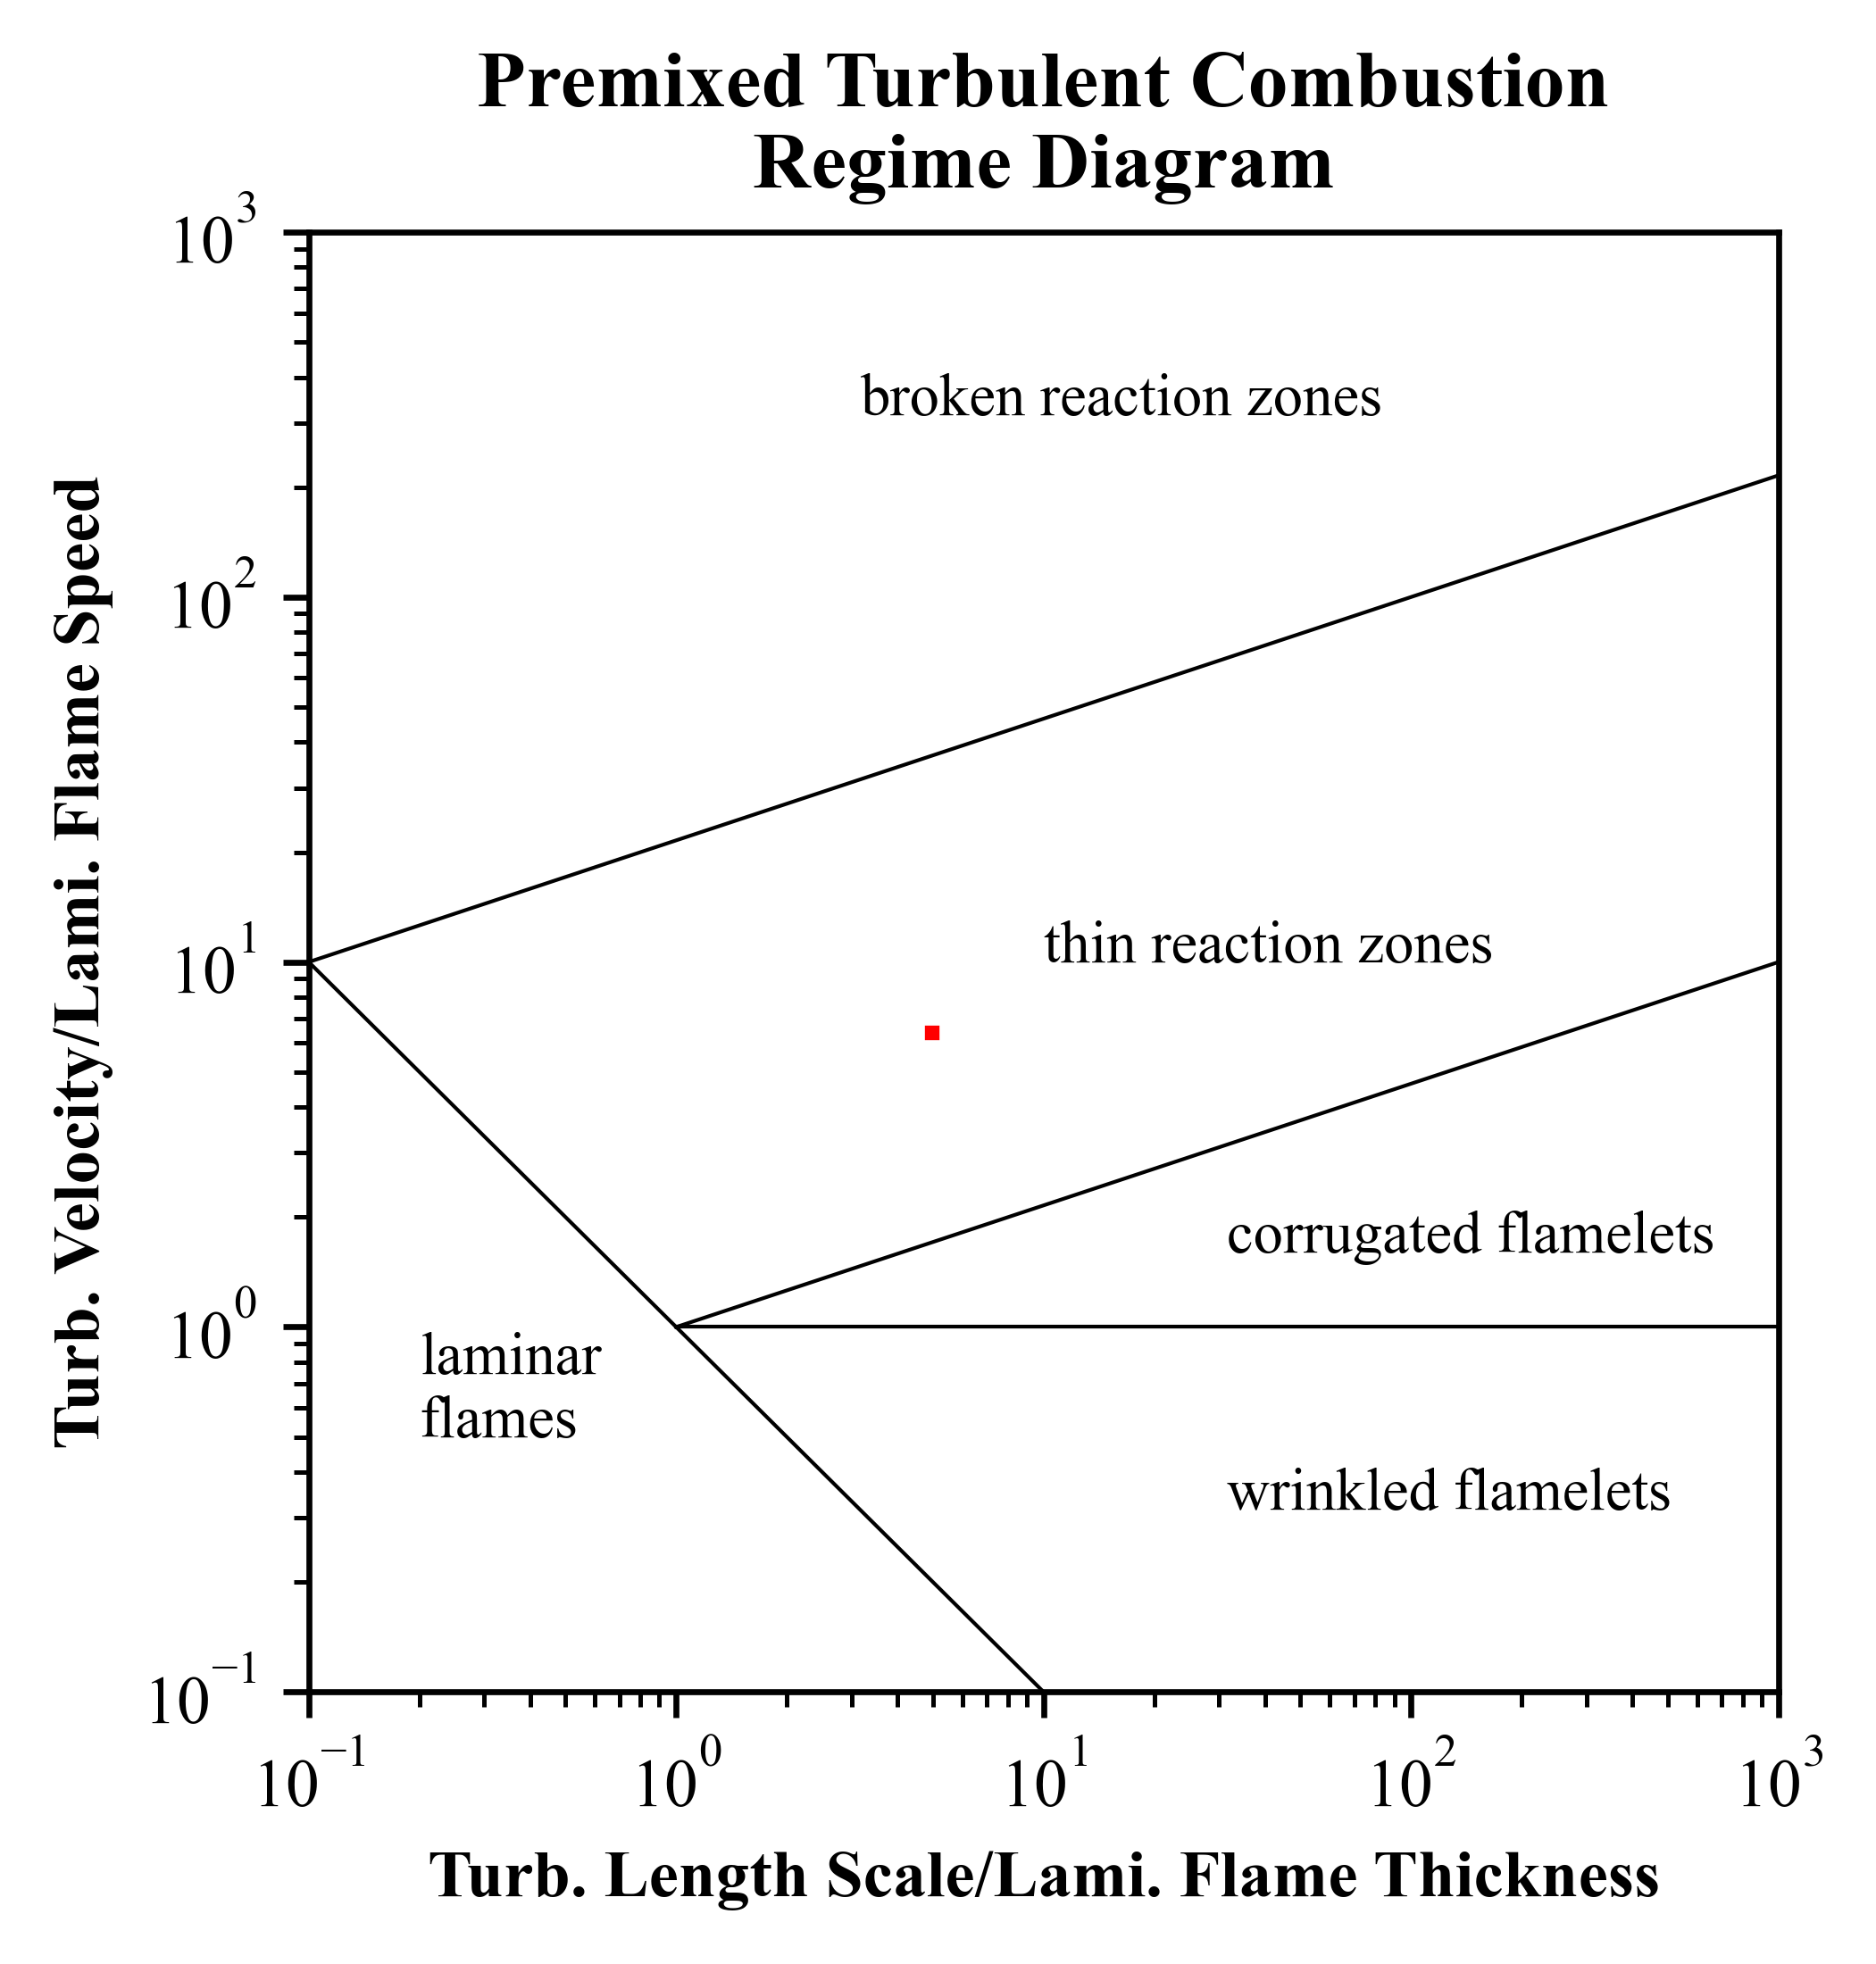

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 9

fig, ax = plt.subplots(1, 1, figsize=(3.54, 3.54), dpi=600)

delta = 0.1
Ka_delta_at_1000 = (1/delta**2*1000**0.5)**(2/3)

ax.plot([0.1, 10],[10, 0.1],color='k',lw=0.5)
ax.plot([0.1, 1000],[10, Ka_delta_at_1000],color='k',lw=0.5)
ax.plot([1, 1000],[1, 10],color='k',lw=0.5)
ax.plot([1, 1000],[1, 1],color='k',lw=0.5)
# ax.plot([0.1, 1000],[0.1, 1000],color='b',linestyle='--',lw=0.5)
# ax.plot([0.1, 1000],[0.05, 500],color='b',linestyle='--',lw=0.5)
# ax.plot([0.1, 1000],[0.2, 2000],color='b',linestyle='--',lw=0.5)

for i, case in enumerate(case_list):
    if Ka[i] > 1/delta**2:
        ax.plot(x[i], y[i], 'bs', markersize=1)
    else:
        ax.plot(x[i], y[i], 'rs', markersize=1)

ax.text(10, 10, "thin reaction zones", fontsize=8)
ax.text(31.6, 1.6, "corrugated flamelets", fontsize=8)
ax.text(31.6, 0.316, "wrinkled flamelets", fontsize=8)
ax.text(3.16, 316, "broken reaction zones", fontsize=8)
ax.text(0.2, 0.5, "laminar\nflames", fontsize=8)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(0.1, 1000)
ax.set_ylim(0.1, 1000)
ax.set_title("Premixed Turbulent Combustion\nRegime Diagram",fontweight='bold')
ax.set_xlabel("Turb. Length Scale/Lami. Flame Thickness",fontweight='bold')
ax.set_ylabel("Turb. Velocity/Lami. Flame Speed",fontweight='bold')


In [8]:
import re

def write_dict(file_path, key, value):
    with open(file_path, "r+") as file:
        content = file.read()

        pattern = r"(\s*" + re.escape(key) + r"\s*)(\S+)(;)"
        new_content = re.sub(pattern, r"\g<1>" + value + r"\g<3>", content)

        file.seek(0)

        file.write(new_content)

        file.truncate()
        
def write_dict_string(file_path, key, value):
    with open(file_path, "r+") as file:
        content = file.read()

        pattern = r'(\s*' + re.escape(key) + r'\s*")(\S+)(";)'
        new_content = re.sub(pattern, r'\g<1>' + value + r'\g<3>', content)

        file.seek(0)

        file.write(new_content)

        file.truncate()
        
def replace_numbers(file_path, replacement):
    with open(file_path, 'r+') as file:
        content = file.read()

        vertices_pattern = r"vertices\n\(\n.*?\n\);"
        number_pattern = r"(\s+\()(\s*)(\d+(?:\.\d+)?)(\s*)(\d+(?:\.\d+)?)(\s*)(\d+(?:\.\d+)?)(\s*)(\))"

        # Find the vertices section in the content
        match = re.search(vertices_pattern, content, re.DOTALL)
        
        def repl(match):
            g = match.groups()
            return g[0] +g[1]+ (replacement if g[2] != '0' else g[2])+ \
                g[3] + (replacement if g[4] != '0' else g[4]) + g[5] \
                + (replacement if g[6] != '0' else g[6]) + g[7] + g[8]

        if match:
            vertices_section = match.group()

            modified_section = re.sub(number_pattern, repl, vertices_section)

            content = content.replace(vertices_section, modified_section)


        file.seek(0)
        file.write(content)
        file.truncate()
        
def setFields_replace_numbers(file_path, replacement):
    with open(file_path, 'r+') as file:
        content = file.read()

        pattern = r"(\s*(?:p1|p2)\s*\()(\s*)(\d+(?:\.\d+)?)(\s+)(\d+(?:\.\d+)?)(\s+)(\d+(?:\.\d+)?)(\s*)(\)\;)"

        value1 = f"{replacement/2:.8f}"
        value2 = f"{replacement:.8f}"
        
        def repl(match):
            g = match.groups()
            return g[0] +g[1]+ (value1 if g[2] != '0' else g[2])+ \
                g[3] + (value1 if g[4] != '0' else g[4]) + g[5] \
                + (value2 if g[6] != '0' else g[6]) + g[7] + g[8]

        new_content = re.sub(pattern, repl, content)

        file.seek(0)
        file.write(new_content)
        file.truncate()

In [9]:
import shutil
def setFieldsDictHandler_2DHIT(species_names, mass_fractions, format_length):
    line = f"    volScalarFieldValue " + f"{species_names:<{format_length}}" + f"{mass_fractions:>18.10f}" + "\n"
    
    return line

def setFieldsDictHandler_2DHIT_cy(species_names, mass_fractions, format_length):
    line = f"            volScalarFieldValue " + f"{species_names:<{format_length}}" + f"{mass_fractions:>18.10f}" + "\n"
    
    return line

def delete_lines(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    new_lines = [line for line in lines if 'volScalarFieldValue' not in line]

    with open(file_path, 'w') as file:
        file.writelines(new_lines)
        
def duplicate_and_modify(file_name, new_file_name, keyword, replacement):
    shutil.copy(file_name, new_file_name)

    with open(new_file_name, 'r') as file:
        lines = file.readlines()

    if len(lines) >= 14:
        lines[13] = lines[13].replace(keyword, replacement)

        with open(new_file_name, 'w') as file:
            file.writelines(lines)


In [10]:
equilibrium_gases = [case.set_equilibrium() for case in case_list]

import subprocess
import os
from pathlib import Path
import shutil
import re

pwd = Path.cwd()
example_dir = pwd / "0_example"


for i, case in enumerate(case_list):
    # equilibrium_gases[i]()
    case_name = f"{i+1}_" + case.fuel_composition + f"_ER{case.equivalence_ratio:.3f}"
    for char in [":", ".", ","]:
        case_name = case_name.replace(char, "")
    case_dir = pwd / case_name
    
    if not case_dir.exists():
        shutil.copytree(example_dir, case_dir)
    
    controlDict_path = case_dir / "system" / "controlDict"

    key = "deltaT"
    replacement_string = str(CFD_dT)

    write_dict(controlDict_path, key, replacement_string)
    
    CanteraTorch_path = case_dir / "constant" / "CanteraTorchProperties"
    key = "inertSpecie"
    value = inert_specie
    write_dict_string(CanteraTorch_path, key, value)
    
    key = "CanteraMechanismFile"
    value = mechanism
    write_dict_string(CanteraTorch_path, key, value)
    
    key = "torch"
    value = "off"
    write_dict(CanteraTorch_path, key, value)
    
    key = "chemistry"
    value = "on"
    write_dict(CanteraTorch_path, key, value)
    
    blockMeshDict_path = case_dir / "system" / "blockMeshDict"
    replace_numbers(blockMeshDict_path, f"{domain_sizes[i]*100:.8f}")
        

In [11]:
for i, case in enumerate(case_list):
    # equilibrium_gases[i]()
    case_name = f"{i+1}_" + case.fuel_composition + f"_ER{case.equivalence_ratio:.3f}"
    for char in [":", ".", ","]:
        case_name = case_name.replace(char, "")
    case_dir = pwd / case_name
    
    species_names = case.species_names
    H2O_index = species_names.index('H2O')
    inert_specie_index = species_names.index(inert_specie)
    # print("Species List:")
    # print(species_names)
    print(f"Found H20 at index = {H2O_index}")
    print(f"Found Inert Specie: {inert_specie} at index = {inert_specie_index}")
    print(f"Continuing...\n")
    n_species = case.num_species

    Y_initial = np.zeros(n_species)
    Y_initial = np.trunc(case.gas.Y * 1e10) / 1e10
    Y_initial[Y_initial < 1e-10] = 0
    # print(Y_initial)
    Y_initial[inert_specie_index] = 1 - sum(Y_initial[_] for _ in range(len(Y_initial)) if _ != inert_specie_index)
    # Y_initial[inert_specie_index] = 1 - np.sum(np.fromiter((Y_initial[_] for _ in range(len(Y_initial)) if _ != inert_specie_index), dtype=float))


    Y_HP = np.zeros(n_species)
    Y_HP = np.trunc(equilibrium_gases[i].Y * 1e10) / 1e10
    Y_HP[Y_HP < 1e-10] = 0
    Y_HP[inert_specie_index] = Y_initial[inert_specie_index]
    Y_HP[H2O_index] = 1 - sum(Y_HP[j] for j in range(len(Y_HP)) if j != H2O_index)
    # Y_HP[H2O_index] = 1 - np.sum(np.fromiter((Y_HP[i] for i in range(len(Y_HP)) if i != H2O_index), dtype=float))
    T_HP = equilibrium_gases[i].T


    print("Writing setFieldsDict File...")
    max_species_length = max(len(species) for species in species_names)

    default_lines = [setFieldsDictHandler_2DHIT('T', T_inlet, max_species_length)]
    for j, mass_fractions in enumerate(Y_initial):
        if mass_fractions != 0:
            default_lines.append(setFieldsDictHandler_2DHIT(species_names[j], mass_fractions, max_species_length))

    cylinder_lines = [setFieldsDictHandler_2DHIT_cy('T', T_HP, max_species_length)]
    for j, mass_fractions in enumerate(Y_HP):
        if mass_fractions != 0:
            cylinder_lines.append(setFieldsDictHandler_2DHIT_cy(species_names[j], mass_fractions, max_species_length))

    setFieldsDict_path = case_dir / "system" / "setFieldsDict"
    
    write_dict(setFieldsDict_path, "radius", f"{domain_sizes[i]/10:.8f}")
    setFields_replace_numbers(setFieldsDict_path, domain_sizes[i])

    with open(setFieldsDict_path, 'r') as file:
        lines = file.readlines()
        
    with open(setFieldsDict_path, 'w') as file:
        lines = [line for line in lines if 'volScalarFieldValue' not in line]
        
        for j, line in enumerate(lines):
            if "defaultFieldValues" in line:
                index = j
                break
        
        lines[index+2:index+2] = default_lines
        
        for j, line in enumerate(lines):
            if "fieldValues" in line:
                index = j
                break
        
        lines[index+2:index+2] = cylinder_lines
        
        file.seek(0)
        file.writelines(lines)


    base_file_name = case_dir / "0" / "Ydefault.orig"
    for j, species_name in enumerate(species_names):
        new_file_name = case_dir / "0" / species_name
        duplicate_and_modify(base_file_name, new_file_name, 'Ydefault', species_name)

Found H20 at index = 5
Found Inert Specie: AR at index = 24
Continuing...

Writing setFieldsDict File...
